In [206]:
# Section 1: Import Libraries and Initial Setup
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime as dt
import os
from plotnine import *
from os import listdir, getcwd

# Working directory setup
os.chdir("/Users/nihao/Downloads")
print(os.getcwd())

# Data Loading
market_data = pd.read_csv(f'{getcwd()}/NL_FR_BE_data_monthly.csv')
firms_info = pd.read_csv(f'{getcwd()}/NL_FR_BE_firms.csv')
ff_factors = pd.read_csv(f'{getcwd()}/Europe_FF_Factors.csv')

# Ensure dates are properly formatted
market_data['mdate'] = pd.to_datetime(market_data['mdate'].astype(str), format='%Y%m')
ff_factors['mdate'] = pd.to_datetime(ff_factors['mdate'].astype(str), format='%Y%m')

/Users/nihao/Downloads


In [207]:
# Sort before lagging 
market_data = market_data.sort_values(by=['ISIN', 'mdate'])
# Lag firm-specific variables used later on 
market_data['ivol'] = market_data.groupby('ISIN')['ivol'].shift(1)  # Lag ivol by 1 month
market_data['RET'] = market_data.groupby('ISIN')['RET'].shift(-1)  # Keep RET at t, lag predictors
# Drop NaN values 
market_data = market_data.dropna()

In [208]:
# Section 2: Strategy Functions
def construct_rolling_vol_long_short_strategy(data, window=12, quantile_low=0.2, quantile_high=0.8, holding_period=1):
    """
    Constructs a rolling volatility long-short strategy
    
    Parameters:
    - data: DataFrame with stock data
    - window: Rolling window length for volatility calculation
    - quantile_low: Lower quantile threshold for low volatility stocks
    - quantile_high: Higher quantile threshold for high volatility stocks
    - holding_period: Number of months to hold the position (1 or 3)
    
    Returns:
    - DataFrame with long-short portfolio returns
    """
    data = data.sort_values(by=['ISIN', 'mdate']).copy()
    
    data['rolling_ivol'] = data.groupby('ISIN')['ivol'].rolling(window, min_periods=window).mean().reset_index(level=0, drop=True)
    
    portfolio_returns = []
    dates = sorted(data['mdate'].unique())
    
    # Determine rebalancing dates based on holding period
    if holding_period == 1:
        rebalance_dates = dates[window:]  # Monthly rebalancing
    elif holding_period == 3:
        rebalance_dates = dates[window::3]  # Quarterly rebalancing
    
    for date_idx, date in enumerate(rebalance_dates):
        # Select stocks for this rebalance date
        monthly_data = data[data['mdate'] == date].copy()
        
        # Define quantiles for rolling volatility
        low_vol_threshold = monthly_data['rolling_ivol'].quantile(quantile_low)
        high_vol_threshold = monthly_data['rolling_ivol'].quantile(quantile_high)
        
        # Select long (low-vol) and short (high-vol) stocks
        low_vol_stocks = monthly_data[monthly_data['rolling_ivol'] <= low_vol_threshold]
        high_vol_stocks = monthly_data[monthly_data['rolling_ivol'] >= high_vol_threshold]
        
        if not low_vol_stocks.empty and not high_vol_stocks.empty:
            # Compute equal-weighted portfolio returns
            long_return = low_vol_stocks['RET'].mean()
            short_return = high_vol_stocks['RET'].mean()
            long_short_return = long_return - short_return
            
            # For current rebalance date
            portfolio_returns.append((date, long_short_return))
            
            # For holding period > 1, add returns for subsequent months without rebalancing
            if holding_period > 1 and date_idx < len(rebalance_dates) - 1:
                next_rebalance_date = rebalance_dates[date_idx + 1]
                
                # Get all dates between current and next rebalance date
                interim_dates = [d for d in dates if date < d < next_rebalance_date]
                
                # Track returns for same stocks during holding period
                for interim_date in interim_dates:
                    interim_data = data[data['mdate'] == interim_date].copy()
                    
                    # Get returns for the same stocks selected at rebalance date
                    low_vol_isins = low_vol_stocks['ISIN'].tolist()
                    high_vol_isins = high_vol_stocks['ISIN'].tolist()
                    
                    interim_low_vol = interim_data[interim_data['ISIN'].isin(low_vol_isins)]
                    interim_high_vol = interim_data[interim_data['ISIN'].isin(high_vol_isins)]
                    
                    if not interim_low_vol.empty and not interim_high_vol.empty:
                        interim_long_return = interim_low_vol['RET'].mean()
                        interim_short_return = interim_high_vol['RET'].mean()
                        interim_long_short_return = interim_long_return - interim_short_return
                        portfolio_returns.append((interim_date, interim_long_short_return))
    
    return pd.DataFrame(portfolio_returns, columns=['mdate', 'Long_Short_RET'])

def construct_improved_rolling_vol_strategy(data, window=12, quantile_low=0.2, quantile_high=0.8, holding_period=1):
    """
    Constructs an improved long-short portfolio based on rolling idiosyncratic volatility (ivol):
    - Excludes high-volatility stocks with negative momentum
    - Uses inverse volatility weighting instead of equal weighting
    
    Parameters:
    - data: DataFrame with stock data
    - window: Rolling window length for volatility calculation
    - quantile_low: Lower quantile threshold for low volatility stocks
    - quantile_high: Higher quantile threshold for high volatility stocks
    - holding_period: Number of months to hold the position (1 or 3)
    
    Returns:
    - DataFrame with improved long-short portfolio returns
    """
    data = data.sort_values(by=['ISIN', 'mdate']).copy()

    
    # Compute rolling volatility and past 12-month momentum 
    data['rolling_ivol'] = data.groupby('ISIN')['ivol'].rolling(window, min_periods=window).mean().reset_index(level=0, drop=True)
    data['momentum'] = data.groupby('ISIN')['RET'].rolling(12, min_periods=12).sum().reset_index(level=0, drop=True)
    
    portfolio_returns = []
    dates = sorted(data['mdate'].unique())
    
    # Determine rebalancing dates based on holding period
    if holding_period == 1:
        rebalance_dates = dates[window:]  # Monthly rebalancing
    elif holding_period == 3:
        rebalance_dates = dates[window::3]  # Quarterly rebalancing
    
    for date_idx, date in enumerate(rebalance_dates):
        # Select stocks for this rebalance date
        monthly_data = data[data['mdate'] == date].copy()
        
        # Define quantiles for rolling volatility
        low_vol_threshold = monthly_data['rolling_ivol'].quantile(quantile_low)
        high_vol_threshold = monthly_data['rolling_ivol'].quantile(quantile_high)
        
        # Select long (low-vol) and short (high-vol) stocks
        low_vol_stocks = monthly_data[monthly_data['rolling_ivol'] <= low_vol_threshold]
        high_vol_stocks = monthly_data[monthly_data['rolling_ivol'] >= high_vol_threshold]
        
        # Exclude high-vol stocks with positive momentum
        high_vol_stocks = high_vol_stocks[high_vol_stocks['momentum'] <= 0]
        
        if not low_vol_stocks.empty and not high_vol_stocks.empty:
            # Compute inverse volatility weighting
            low_vol_weights = 1 / low_vol_stocks['rolling_ivol']
            high_vol_weights = 1 / high_vol_stocks['rolling_ivol']
            
            # Normalize weights
            low_vol_weights /= low_vol_weights.sum()
            high_vol_weights /= high_vol_weights.sum()
            
            # Compute weighted portfolio returns
            long_return = (low_vol_stocks['RET'] * low_vol_weights).sum()
            short_return = (high_vol_stocks['RET'] * high_vol_weights).sum()
            long_short_return = long_return - short_return
            
            # For current rebalance date
            portfolio_returns.append((date, long_short_return))
            
            # For holding period > 1, add returns for subsequent months without rebalancing
            if holding_period > 1 and date_idx < len(rebalance_dates) - 1:
                next_rebalance_date = rebalance_dates[date_idx + 1]
                
                # Get all dates between current and next rebalance date
                interim_dates = [d for d in dates if date < d < next_rebalance_date]
                
                # Track returns for same stocks during holding period
                for interim_date in interim_dates:
                    interim_data = data[data['mdate'] == interim_date].copy()
                    
                    # Get returns for the same stocks selected at rebalance date
                    low_vol_isins = low_vol_stocks['ISIN'].tolist()
                    high_vol_isins = high_vol_stocks['ISIN'].tolist()
                    
                    interim_low_vol = interim_data[interim_data['ISIN'].isin(low_vol_isins)]
                    interim_high_vol = interim_data[interim_data['ISIN'].isin(high_vol_isins)]
                    
                    if not interim_low_vol.empty and not interim_high_vol.empty:
                        # Keep the same weights from rebalance date for simplicity
                        interim_long_return = (interim_low_vol['RET'] * low_vol_weights).sum()
                        interim_short_return = (interim_high_vol['RET'] * high_vol_weights).sum()
                        interim_long_short_return = interim_long_return - interim_short_return
                        portfolio_returns.append((interim_date, interim_long_short_return))
    
    return pd.DataFrame(portfolio_returns, columns=['mdate', 'Improved_Long_Short_RET'])

In [209]:
# Section 3: Performance Evaluation Functions
def calculate_performance_metrics(returns_df, returns_col, ff_data):
    """
    Calculate performance metrics including:
    - Annualized Return
    - Annualized Volatility
    - Sharpe Ratio
    - Information Ratio with respect to market factor
    - Information Ratio with respect to Fama-French 3 factors
    
    Parameters:
    - returns_df: DataFrame with portfolio returns
    - returns_col: Name of the column containing returns
    - ff_data: Fama-French factors data
    
    Returns:
    - DataFrame with performance metrics
    """
    # Merge with Fama-French factors
    merged_data = pd.merge(returns_df, ff_data, on='mdate', how='inner')
    merged_data = merged_data.dropna()
    
    # Calculate annualized metrics
    annualized_return = merged_data[returns_col].mean() * 12
    annualized_volatility = merged_data[returns_col].std() * np.sqrt(12)
    sharpe_ratio = annualized_return / annualized_volatility
    
    # Ensure that there are no missing values in the variables used for regression
    merged_data_ff3 = merged_data.dropna(subset=[returns_col, 'MktRF', 'HML', 'SMB'])
    merged_data_mkt = merged_data.dropna(subset=[returns_col, 'MktRF'])

    # Run Fama-French regression (FF3)
    X_ff3 = merged_data_ff3[['MktRF', 'HML', 'SMB']]
    X_ff3 = sm.add_constant(X_ff3)
    y_ff3 = merged_data_ff3[returns_col]
    model_ff3 = sm.OLS(y_ff3, X_ff3).fit(cov_type='HAC', cov_kwds={'maxlags': 5})
    
    # Calculate the standard deviation of the residuals (for the information ratio)
    residuals_ff3 = model_ff3.resid
    sigma_epsilon_ff3 = np.std(residuals_ff3)

    # Save regression coefficients
    coefs_ff3 = model_ff3.params

    # Information Ratio (risk-adjusted abnormal returns)
    information_ratio_ff3 = coefs_ff3.iloc[0] / sigma_epsilon_ff3
    print('Information Ratio (FF3) =', np.round(information_ratio_ff3, 4))

    # Run Market regression (Mkt)
    X_mkt = merged_data_mkt[['MktRF']]
    X_mkt = sm.add_constant(X_mkt)
    y_mkt = merged_data_mkt[returns_col]
    model_mkt = sm.OLS(y_mkt, X_mkt).fit(cov_type='HAC', cov_kwds={'maxlags': 5})

    # Calculate the standard deviation of the residuals (for the information ratio)
    residuals_mkt = model_mkt.resid
    sigma_epsilon_mkt = np.std(residuals_mkt)

    # Save regression coefficients
    coefs_mkt = model_mkt.params

    # Information Ratio (risk-adjusted abnormal returns)
    information_ratio_mkt = coefs_mkt.iloc[0] / sigma_epsilon_mkt
    print('Information Ratio (Mkt) =', np.round(information_ratio_mkt, 4))
    
    # Store metrics
    performance_metrics = pd.DataFrame({
        'Annualized Return': [annualized_return],
        'Annualized Volatility': [annualized_volatility],
        'Sharpe Ratio': [sharpe_ratio],
        'Information Ratio (FF3)': [information_ratio_ff3],
        'Information Ratio (Mkt)': [information_ratio_mkt],
        'Alpha (annual)': [model_ff3.params['const'] * 12],
        'Market Beta': [model_ff3.params['MktRF']],
        'SMB Beta': [model_ff3.params['SMB']],
        'HML Beta': [model_ff3.params['HML']]
    })
    
    return performance_metrics, model_ff3

def plot_cumulative_returns(returns_df, returns_col, title):
    """
    Plot cumulative returns over time
    
    Parameters:
    - returns_df: DataFrame with portfolio returns
    - returns_col: Name of the column containing returns
    - title: Plot title
    """
    # Calculate cumulative returns
    returns_df['Cumulative_Return'] = (1 + returns_df[returns_col]).cumprod()
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(returns_df['mdate'], returns_df['Cumulative_Return'], label="Cumulative Return", color='blue')
    plt.axhline(1, color='black', linestyle='--', linewidth=0.8)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.title(title)
    plt.legend()
    plt.show()
    
    return returns_df['Cumulative_Return'].iloc[-1] - 1  # Total return

In [210]:
# Section 4: Strategy Comparison with Different Parameters
def compare_strategy_parameters(data, ff_data, window=12, holding_period=3):
    """
    Compare strategy performance with different quantile parameters
    
    Parameters:
    - data: DataFrame with stock data
    - ff_data: Fama-French factors data
    - window: Rolling window length for volatility calculation
    - holding_period: Number of months to hold the position
    """
    # Define different quantile combinations to test
    quantile_pairs = [
        (0.05, 0.95),  # 5% most extreme on each side
        (0.10, 0.90),  # 10% most extreme on each side
        (0.20, 0.80)   # 20% most extreme on each side
    ]
    
    results = []
    
    for low_q, high_q in quantile_pairs:
        # Regular strategy
        portfolio = construct_rolling_vol_long_short_strategy(
            data, window=window, quantile_low=low_q, quantile_high=high_q, holding_period=holding_period
        )
        metrics, _ = calculate_performance_metrics(portfolio, 'Long_Short_RET', ff_data)
        
        # Add identifier
        metrics['Strategy'] = 'Regular'
        metrics['Long %'] = low_q * 100
        metrics['Short %'] = (1 - high_q) * 100
        metrics['Holding Period'] = holding_period
        
        results.append(metrics)
        
        # Improved strategy
        improved_portfolio = construct_improved_rolling_vol_strategy(
            data, window=window, quantile_low=low_q, quantile_high=high_q, holding_period=holding_period
        )
        improved_metrics, _ = calculate_performance_metrics(improved_portfolio, 'Improved_Long_Short_RET', ff_data)
        
        # Add identifier
        improved_metrics['Strategy'] = 'Improved'
        improved_metrics['Long %'] = low_q * 100
        improved_metrics['Short %'] = (1 - high_q) * 100
        improved_metrics['Holding Period'] = holding_period
        
        results.append(improved_metrics)
    
    # Combine all results
    combined_results = pd.concat(results)
    return combined_results


Running volatility long-short strategy analysis...

Comparing strategies with different parameters (3-month holding period):
Information Ratio (FF3) = -0.1062
Information Ratio (Mkt) = -0.0921
Information Ratio (FF3) = 0.2718
Information Ratio (Mkt) = 0.2782
Information Ratio (FF3) = -0.0809
Information Ratio (Mkt) = -0.0638
Information Ratio (FF3) = 0.3235
Information Ratio (Mkt) = 0.3321
Information Ratio (FF3) = -0.0531
Information Ratio (Mkt) = -0.037
Information Ratio (FF3) = 0.3606
Information Ratio (Mkt) = 0.3685

Comparison Results:
   Annualized Return  Annualized Volatility  Sharpe Ratio  \
0          -0.076852               0.221232     -0.347381   
0           0.135273               0.142389      0.950026   
0          -0.045360               0.178528     -0.254076   
0           0.129572               0.113745      1.139147   
0          -0.024605               0.139711     -0.176114   
0           0.128096               0.102495      1.249782   

   Information Ratio (FF3

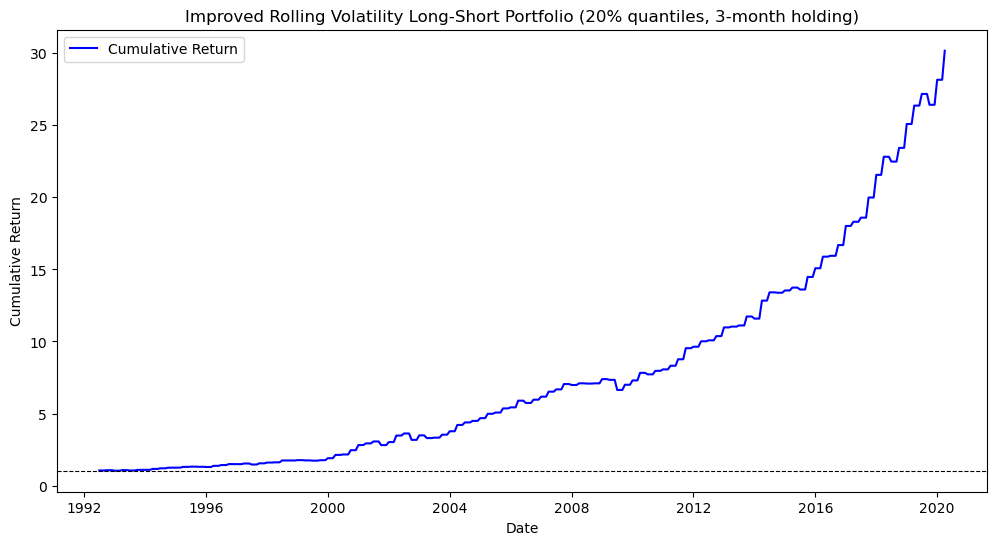

Total Return: 2917.65%


In [211]:
# Section 5: Main Execution Code
def main():
    # Prepare data
    print("Running volatility long-short strategy analysis...")
    
    # Test strategy with different parameters (3-month holding period)
    print("\nComparing strategies with different parameters (3-month holding period):")
    comparison_results = compare_strategy_parameters(market_data, ff_factors, window=12, holding_period=3)
    print("\nComparison Results:")
    print(comparison_results)
    
    # Run the best strategy based on the comparison (for example, 10% quantiles)
    print("\nRunning best strategy (20% quantiles, 3-month holding period):")
    best_portfolio = construct_improved_rolling_vol_strategy(
        market_data, window=12, quantile_low=0.20, quantile_high=0.80, holding_period=3
    )
    
    # Calculate metrics and plot results
    best_metrics, best_model = calculate_performance_metrics(
        best_portfolio, 'Improved_Long_Short_RET', ff_factors
    )
    
    print("\nPerformance Metrics for Best Strategy:")
    print(best_metrics)
    
    print("\nFama-French 3-Factor Regression Results:")
    print(best_model.summary())
    
    print("\nPlotting cumulative returns...")
    total_return = plot_cumulative_returns(
        best_portfolio, 'Improved_Long_Short_RET', 
        "Improved Rolling Volatility Long-Short Portfolio (20% quantiles, 3-month holding)"
    )
    print(f"Total Return: {total_return:.2%}")

if __name__ == "__main__":
    main()